# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [1]:
import condensate_speckle
from condensate_speckle.data_io import*
from condensate_speckle.inference.model import*
from condensate_speckle.inference.simulation import *

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
az.style.use("arviz-darkgrid")

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

We need to specify three variables in order to build the generative model: the mean $c$ and standard deviation $\sigma_e$ of the innovation term $e_t$, and decay time $\tau$. Here, $e_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

# Load in real data

/Users/anqichen/Documents/GitHub/condensate_speckles/condensate_speckle/example_data/[120, 145]_intensity.csv


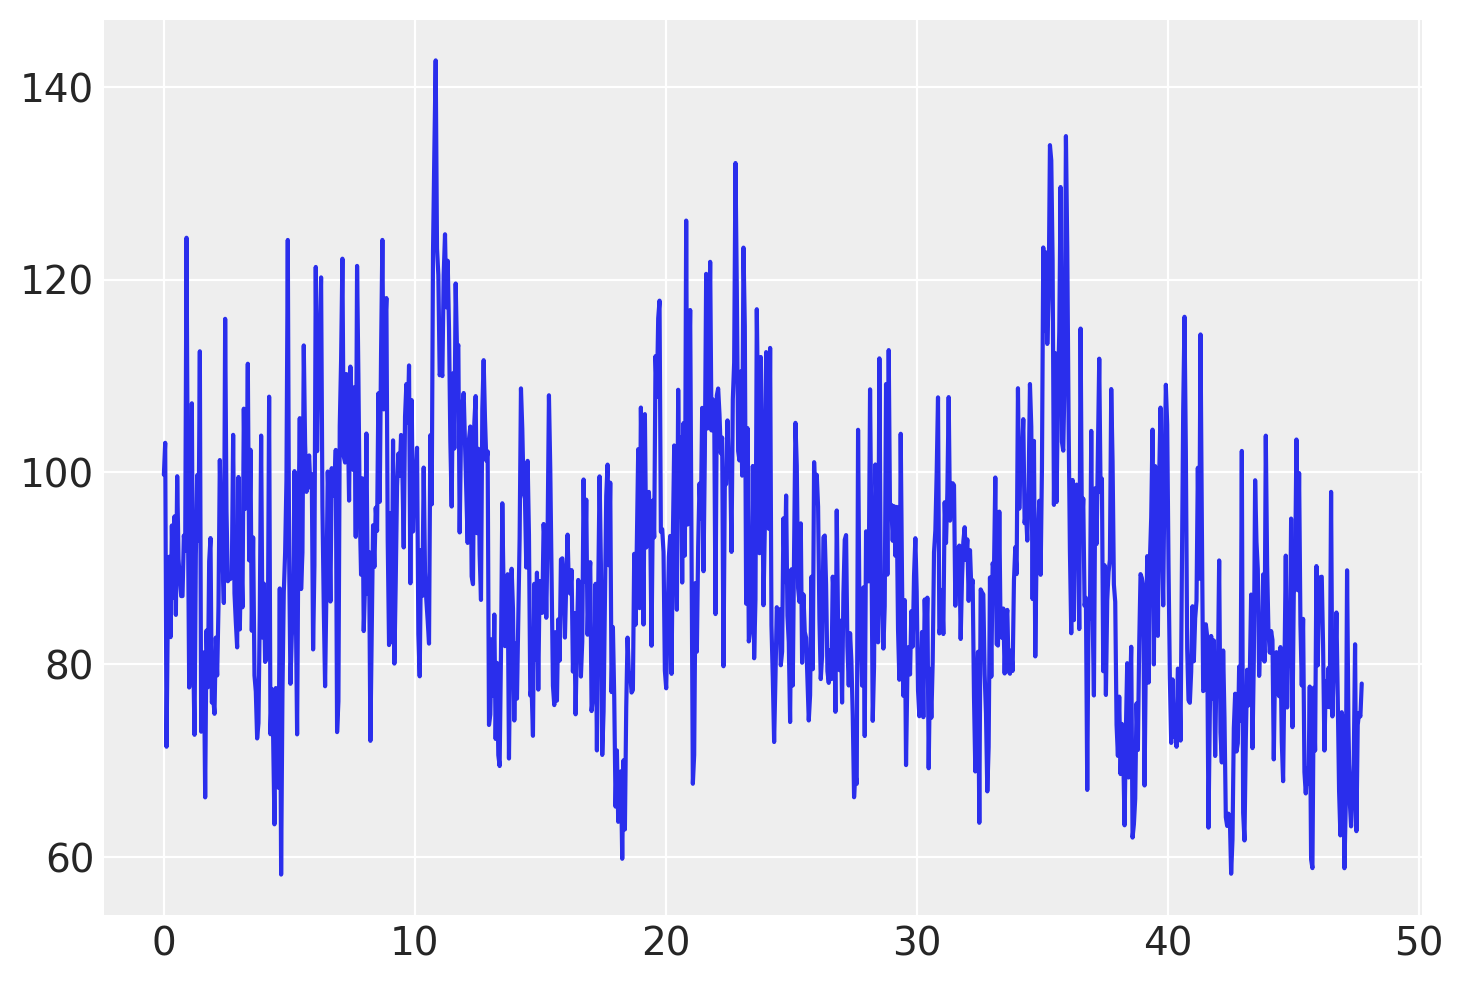

In [3]:
quantization = 255
dataframe = load_data('[120, 145]_intensity.csv',data_dir='condensate_speckle/example_data')

# Infer decay time from data using the AR(1) model in pymc3

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [4]:
# Define ar1 model
ar1_model=set_model(dataframe['Intensity'],quantization)

In [5]:
# Sample with pymc3 using the single timescale model
trace_single_model = run_model(ar1_model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,673.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, noise_std, precision, decay_time]


/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


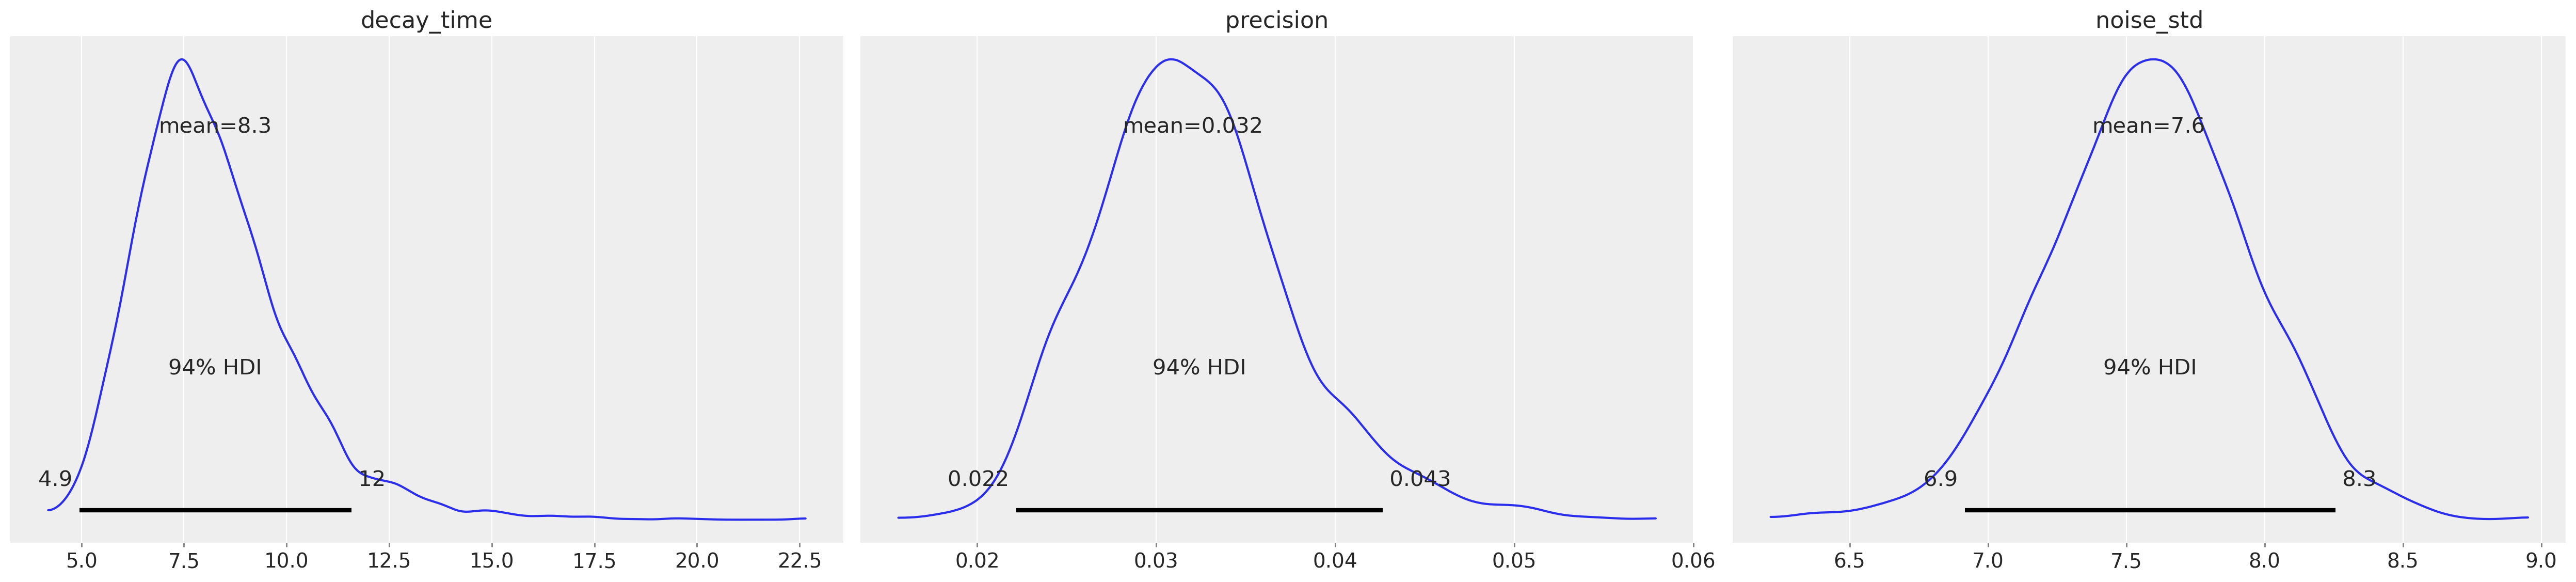

In [6]:
plot_posterior(trace_single_model)

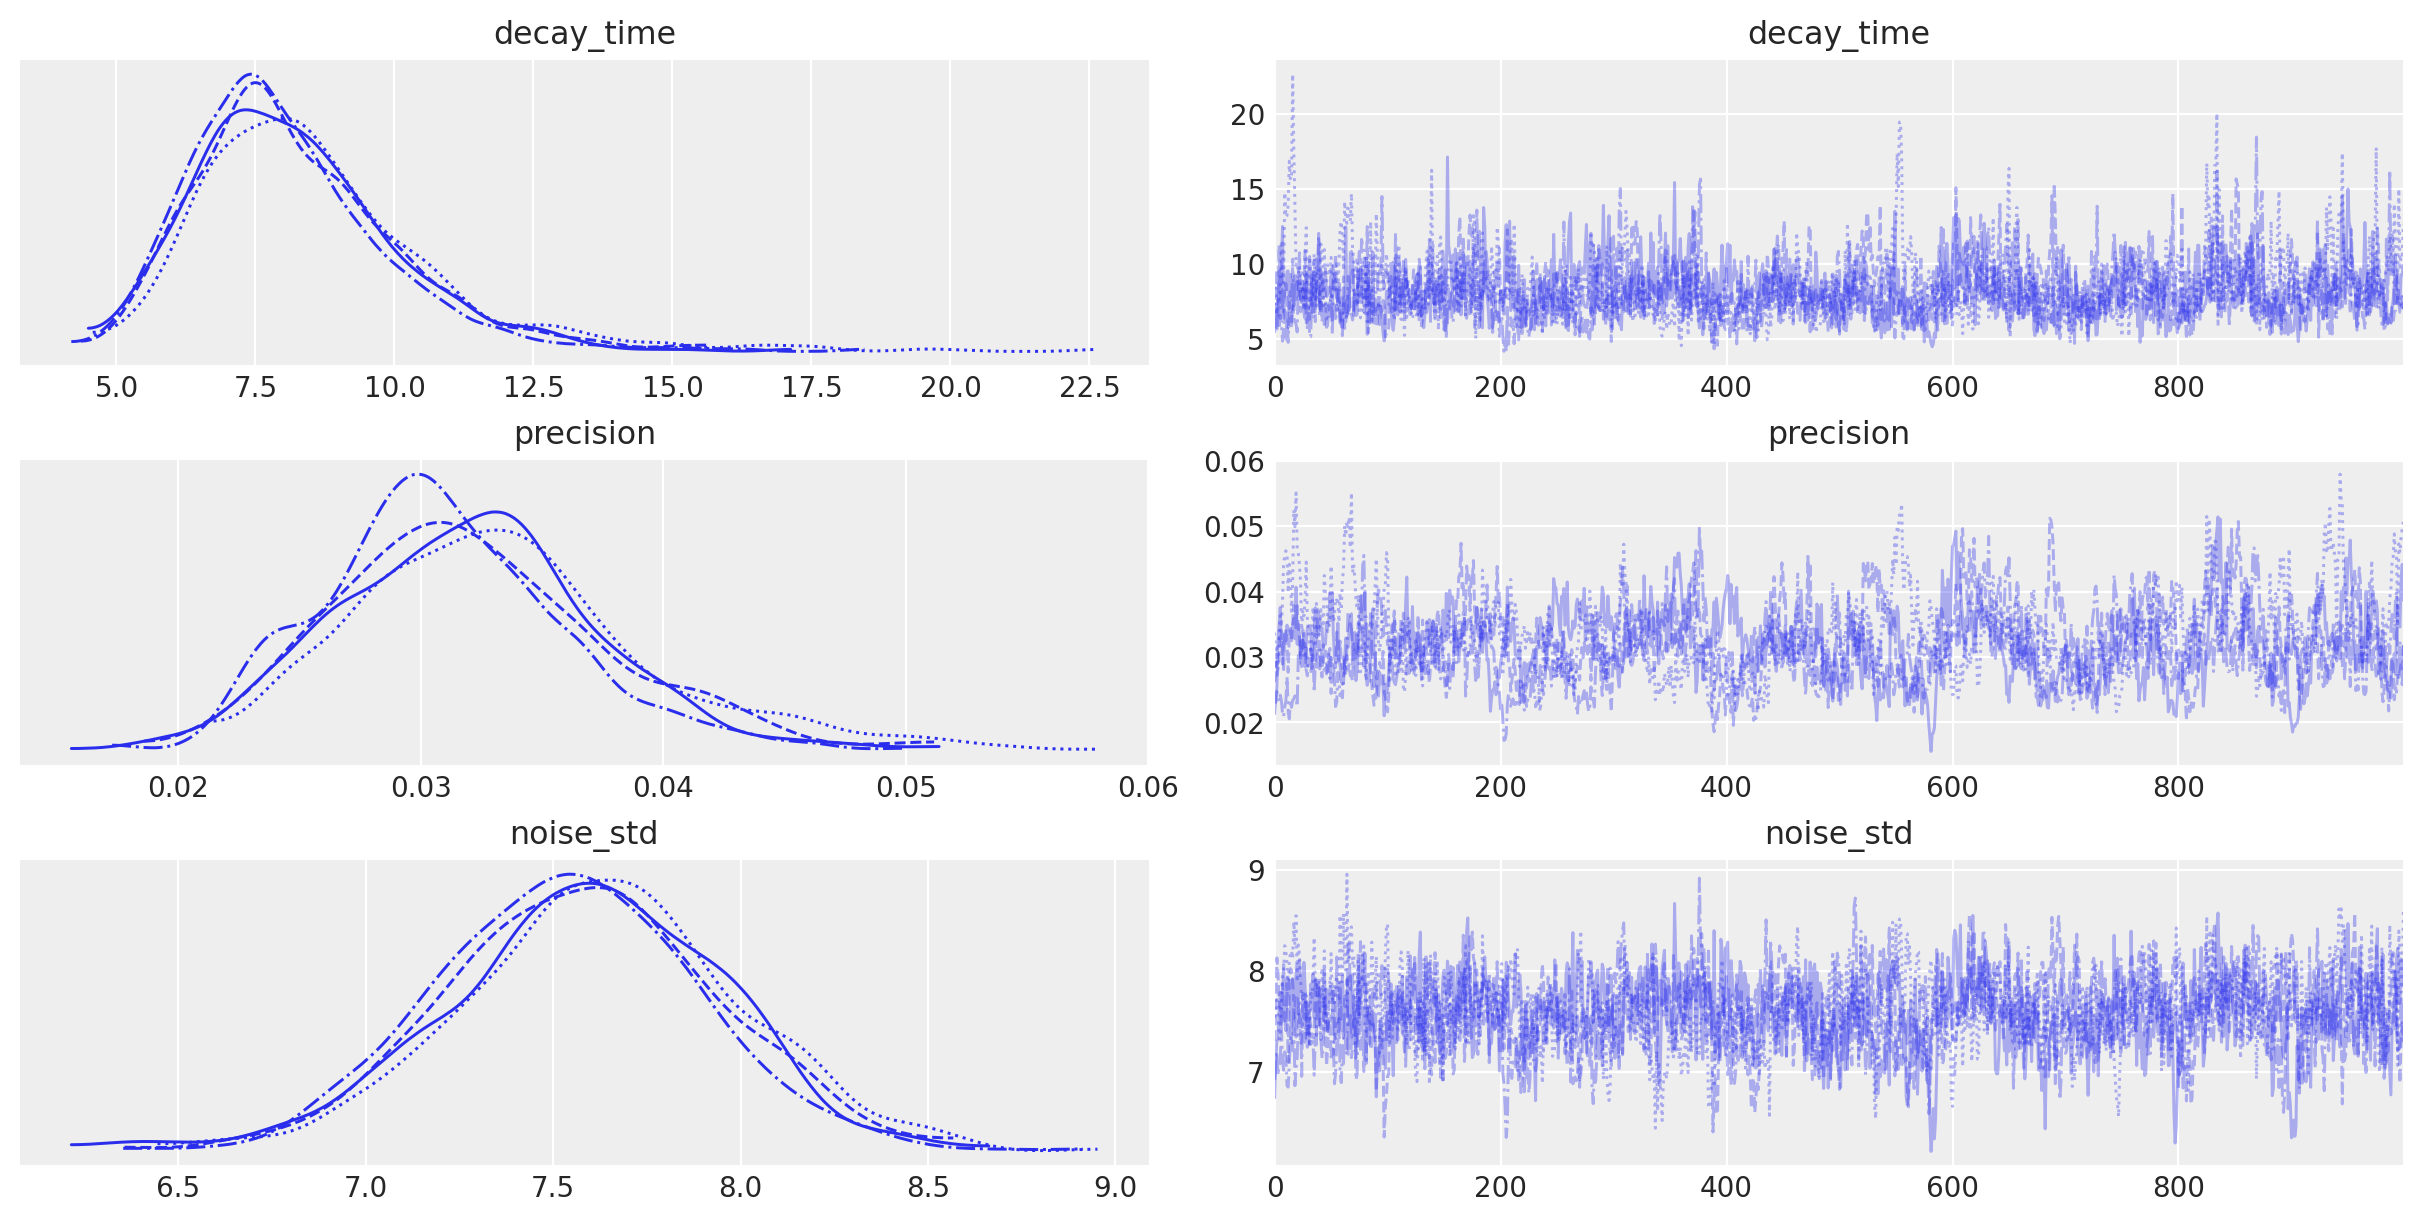

In [7]:
plot_trace(trace_single_model)

# Infer decay time from data using the 2*AR(1) model in pymc3

In [8]:
ar1_multi_model=set_single_precision_model(dataframe['Intensity'], quantization)

In [9]:
# Sample with pymc3 using the double timescale model
trace_multi_model = run_model(ar1_multi_model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,695.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, noise_std, precision, decay_time_split, decay_time_1]


/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 51 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


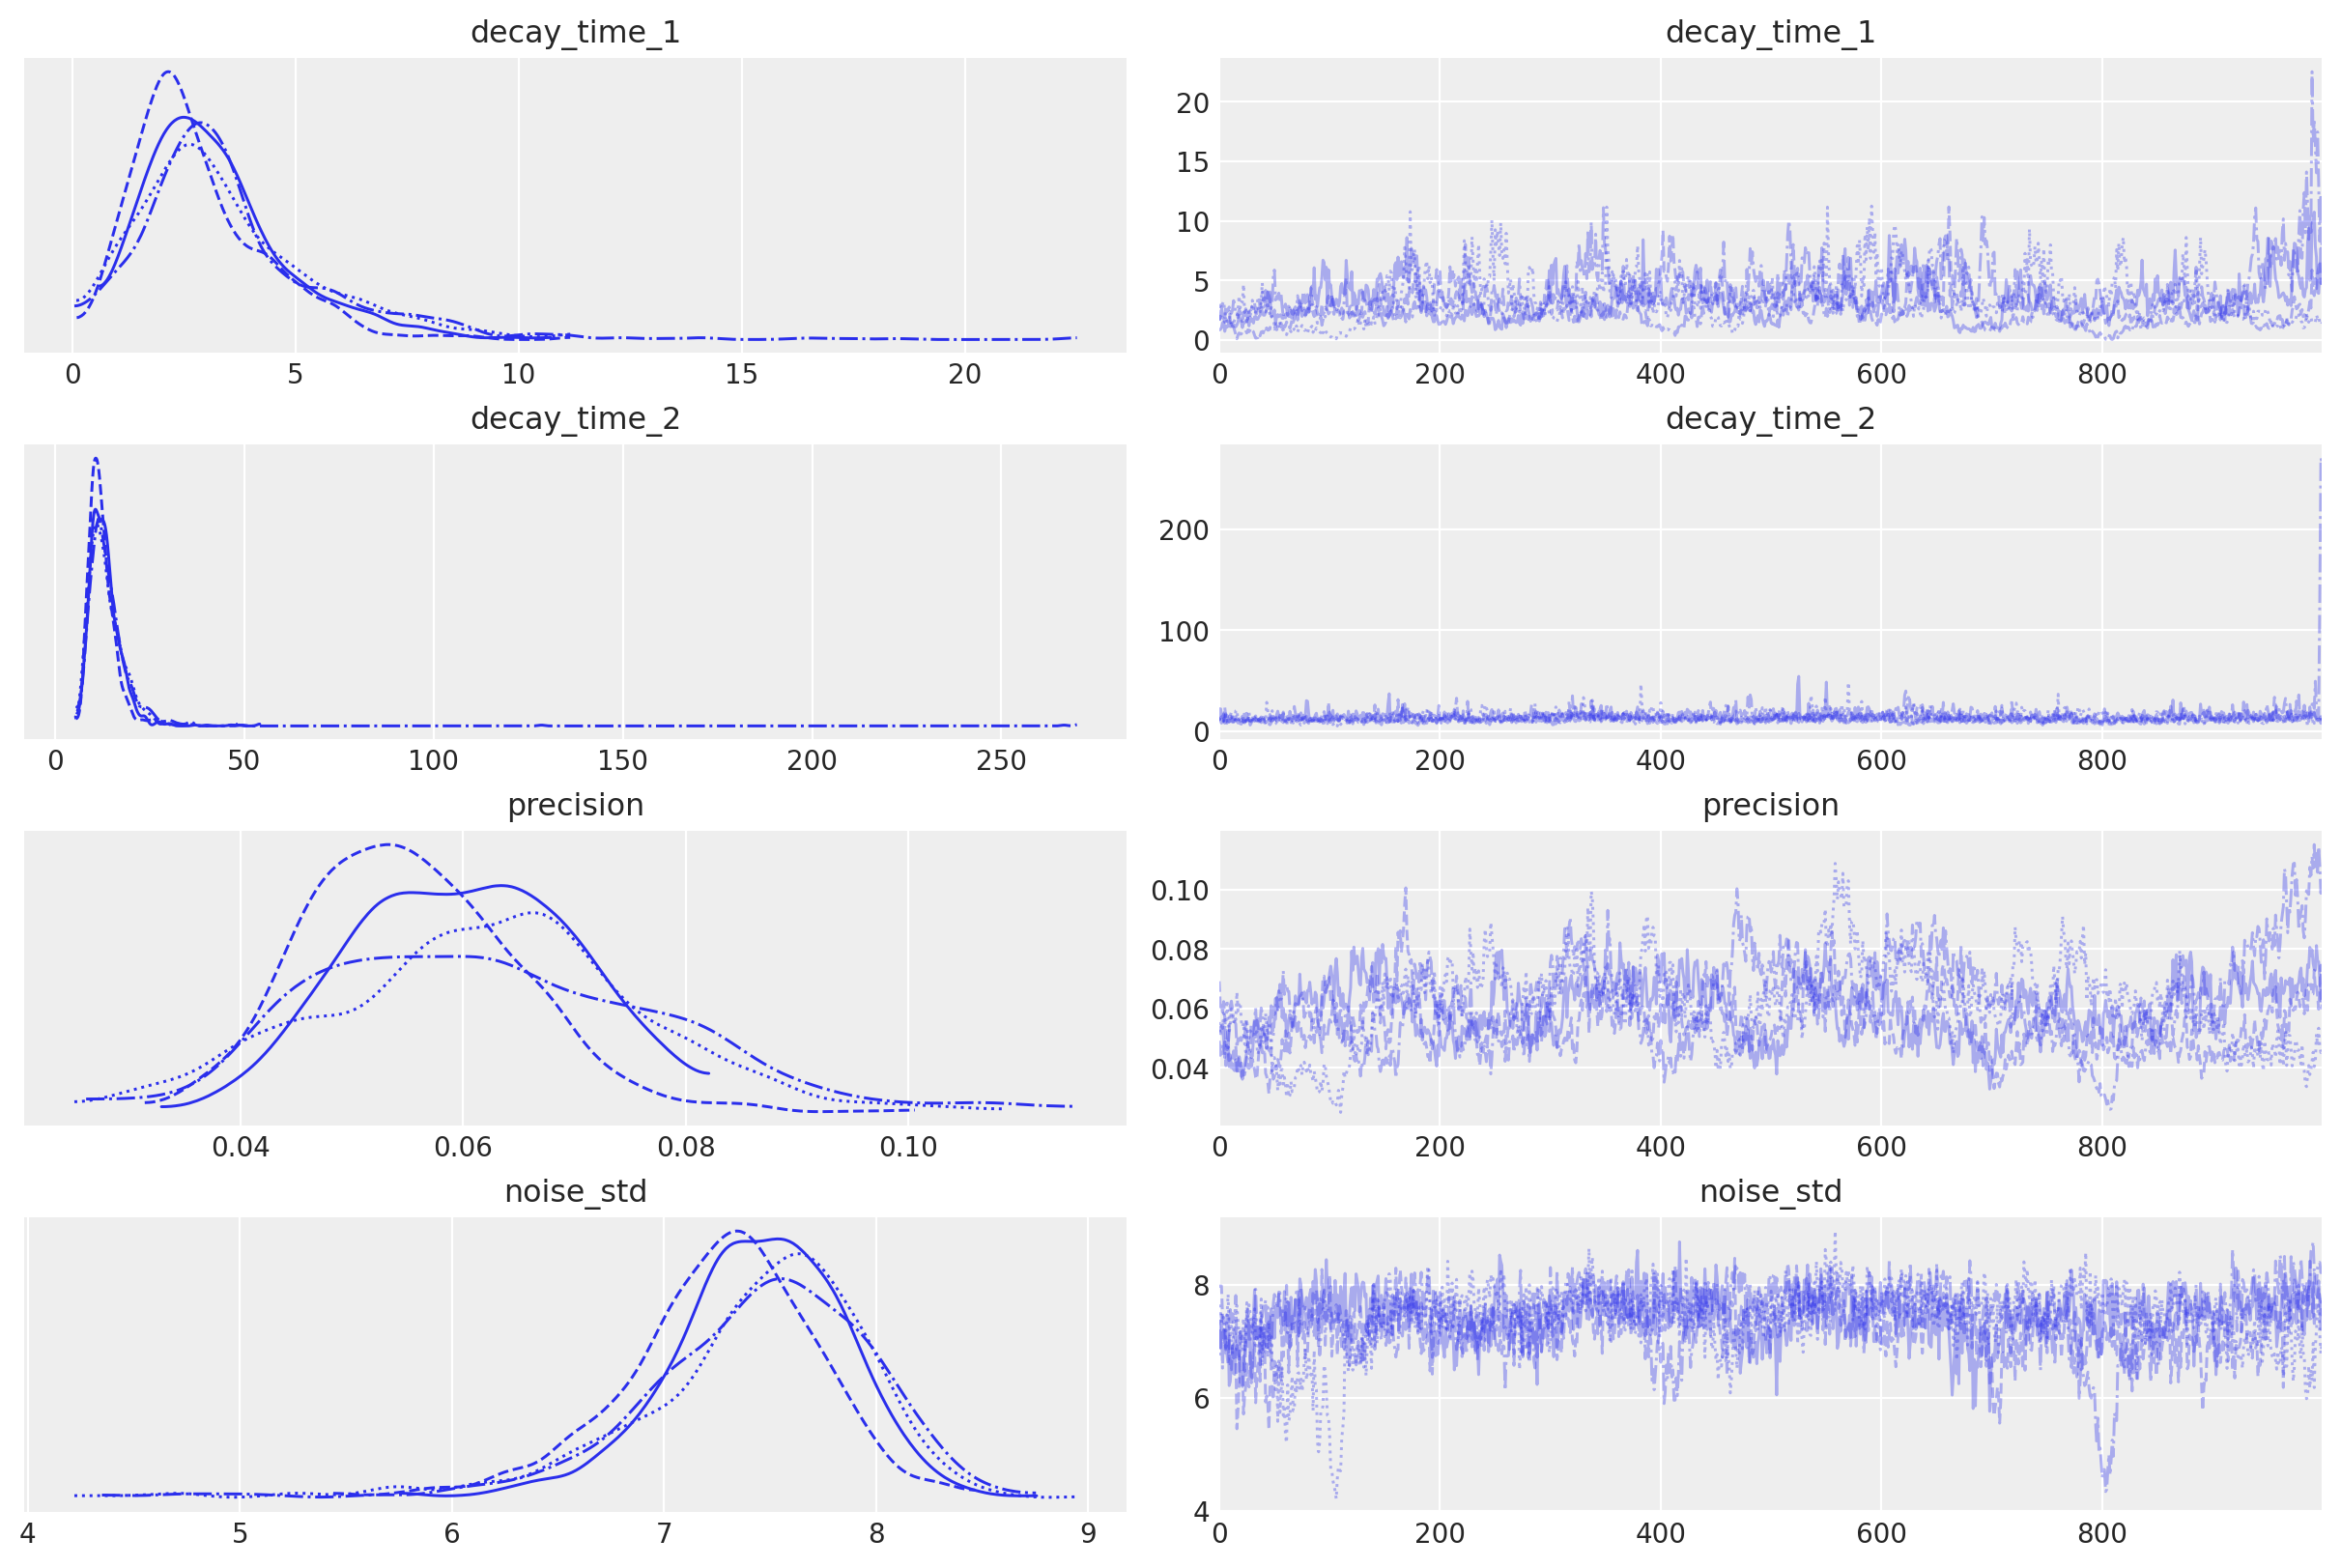

In [10]:
plot_trace(trace_multi_model, n_time_scale = 2)

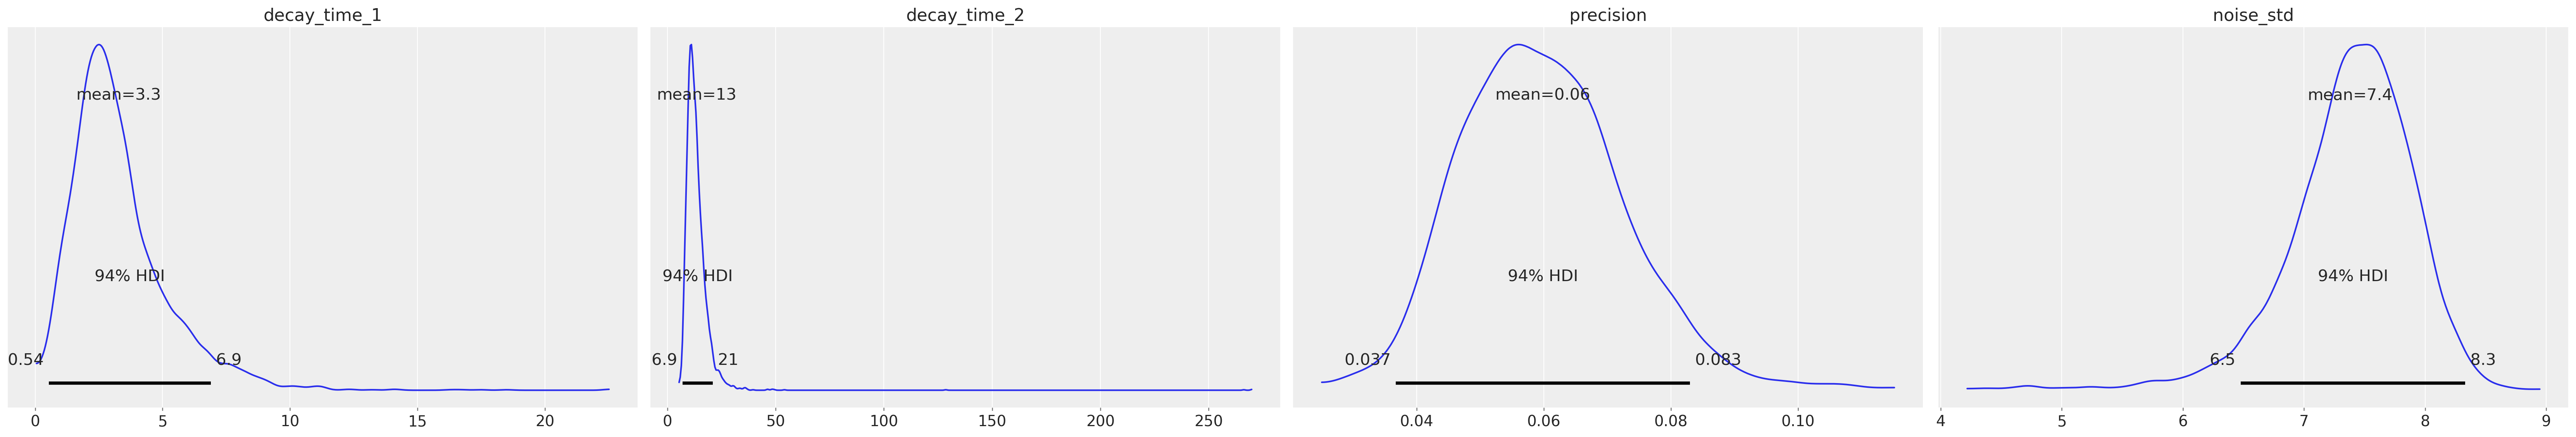

In [11]:
plot_posterior(trace_multi_model, n_time_scale = 2)